# Scenarios to run SBI library on

***Note*** matplotlib is required for visualizing results in part 4
***Note*** before proceeding replace database and pdb files with ones that match locations on your system

In [1]:
from SBI.external.blast import BlastExe
from SBI.structure import PDB 
from SBI.databases import PDBlink
from SBI.structure import Complex
import re
import math

## 1) Blast and print alignment in pir format for modeller

In [3]:
protein = PDB("pdb1a3q.ent.gz")
blast = BlastExe(database = "/home/pgohl/Work/pgohl/ModCRE/scripts/databases/sequences.fa")
ChainA = protein.get_chain_by_id("A")
sequence = ChainA.protein_sequence
blastresults = blast.execute_query_seq(sequenceID = "1A3Q_A", sequence = sequence)
##### The alignment that we want to match
PIR = blastresults.str_PIR(result=2)
print(PIR)

>P1;1A3Q_A
sequence:1A3Q_A:1:.:285:.:.:.:.:.
GPYLVIVEQPKQRGFRFRYGCEGPSHGGLPGASSEKGRKTYPTVKICNYEGPAKIEVDLV
THSDPPRAHAHSLVGKQCSELGICAVSVGPKDMTAQFNNLGVLHVTKKNMMGTMIQKLQR
QRLRSRPQG-------------------LTEAEQRELEQEAKELKKVMDLSIVRLRFSAF
L------RSLPLKPVISQPIHDSKSPGASNLKISRMDKTAGSVRGGDEVYLLCDKVQKDD
IEVRFYEDDENG--WQAFGDFSPTDVHKQYAIVFRTPPYHKMKIERPVTVFLQLKRKRGG
DVSDSKQFTYYP*
>P1;1LE5
structureX:1LE5:2:F:312:F:.:.:.:.
GPYLQILEQPKQRGFRFRYVCEGPSHGGLPGASSEKNKKSYPQVKICNYVGPAKVIVQLV
TNGKNIHLHAHSLVGKHC-EDGVCTVTAGPKDMVVGFANLGILHVTKKKVFETLEARMTE
ACIRGYNPGLLVHSDLAYLQAEGGGDRQLTDREKEIIRQAAVQQTKEMDLSVVRLMFTAF
LPDSTGSFTRRLEPVVSDAIYDSKAPNASNLKIVRMDRTAGCVTGGEEIYLLCDKVQKDD
IQIRFYEEEENGGVWEGFGDFSPTDVHRQFAIVFKTPKYKDVNITKPASVFVQLRRKSDL
ETSEPKPFLYYP*


## 2) Change the residue numbering of a protein to match that of an alignment.

In [4]:
PIRlist = PIR.split(">P1;")
p1a3q = "".join(PIRlist[1].split("\n")[2:])
blasthit = "".join(PIRlist[2].split("\n")[2:])
hit_ID = "".join(PIRlist[2].split("\n")[0])
new = PDBlink()
path = new.get_PDB(hit_ID)
proteinmatch = PDB(path)
MatchChainStart = PIRlist[2].split(":")[2]
index = int(MatchChainStart) - 1
for x in range(0 , len(ChainA.aminoacids)):
	while p1a3q[index] == "-" :
		index = index + 1
	ChainA.aminoacids[x].number = index + 1
	index = index + 1

## 3) Calculate a proteins loops in a chain

In [5]:
ChainA.calculate_dssp()
ChainA.calculate_archs()
ChainA.archs
ChainA.superarchs
for chain in proteinmatch.chain_identifiers:
	ChainB = proteinmatch.get_chain_by_id(chain)
	if str(type(ChainB)) != "<class 'SBI.structure.chain.ChainOfProtein.ChainOfProtein'>":
		continue
	ChainB.calculate_dssp()
	ChainB.calculate_archs()
	##### Here I will compare loops between ChainA and ChainB using FragRus´s most conservative thresholds
	for loop in ChainA.archs:
		for x in ChainB.archs:
			Rho = math.sqrt((loop.rho - x.rho)**2) <= 10 
			Delta = math.sqrt((loop.delta - x.delta)**2) <= 5
			Theta = math.sqrt((loop.theta - x.theta)**2) <= 5
			Distance = math.sqrt((loop.cartesian_distance - x.cartesian_distance)**2) <= 0.5 
			if Distance and Rho and Delta and Theta:
				print("\n{0}\n{1}\n".format(loop.line_format(),x.line_format()))

('1A3Q_A.47.pdb', '1A3Q_A.47.dssp')


truncated chain!1A3Q_A.47.dssp


('1LE5_B.6.pdb', '1LE5_B.6.dssp')

1A3Q_A_221	BK	5	009.982	140.219	161.534	123.887	0
1LE5_B_257	BK	5	010.085	142.720	168.878	122.014	0

('1LE5_F.78.pdb', '1LE5_F.78.dssp')

1A3Q_A_221	BK	5	009.982	140.219	161.534	123.887	0
1LE5_F_257	BK	5	010.083	142.767	169.466	122.070	0


1A3Q_A_264	GE	0	002.858	077.184	138.966	086.786	0
1LE5_F_300	GE	0	003.037	074.437	129.056	082.366	0


1A3Q_A_267	BN	3	004.681	162.018	346.400	098.084	0
1LE5_F_303	BN	3	004.528	162.968	354.902	099.187	0

('1LE5_A.73.pdb', '1LE5_A.73.dssp')

1A3Q_A_264	GE	0	002.858	077.184	138.966	086.786	0
1LE5_A_241	GE	0	003.067	075.588	134.834	085.114	0


1A3Q_A_267	BN	3	004.681	162.018	346.400	098.084	0
1LE5_A_244	BN	3	004.722	163.636	348.472	100.986	0

('1LE5_E.33.pdb', '1LE5_E.33.dssp')

1A3Q_A_196	BK	3	011.878	046.013	071.042	020.982	0
1LE5_E_172	BK	3	012.134	041.016	080.811	022.251	0



## 4) Getting the loop geometry values of all 1A3Q_A_19 BLAST hits

#### This loop is a beta-link 

In [6]:
ChainA = protein.get_chain_by_id("A")
tempMatch = "<<<<<<<<" + ChainA.protein_sequence + ">>>>>>>>"
search = r'.{4}' + ChainA.archs[1].aminoacid_sequence + r'.{4}'
blastSearch = re.findall(search, tempMatch)[0].strip("<>")
tempblastresults = blast.execute_query_seq(sequenceID = ChainA.archs[1].identifier, sequence = blastSearch)
Rholist = []
Deltalist = []
Thetalist = []
identities = []
for hit in tempblastresults.get_hits():
	id,chain = hit.sequenceID.split("_")
	path = new.get_PDB(id)
	proteinmatch = PDB(path)
	ChainB = proteinmatch.get_chain_by_id(chain)
	ChainB.calculate_dssp()
	ChainB.calculate_archs()
	for x in ChainB.archs:
		if x.aminoacid_sequence in hit.hit_seq:
			Rho = math.sqrt((ChainA.archs[1].rho - x.rho)**2)
			Delta = math.sqrt((ChainA.archs[1].delta - x.delta)**2)
			Theta = math.sqrt((ChainA.archs[1].theta - x.theta)**2)
			Distance = math.sqrt((ChainA.archs[1].cartesian_distance - x.cartesian_distance)**2)
			Rholist.append(Rho)
			Deltalist.append(Delta)
			Thetalist.append(Theta)
			identities.append(hit.identities_pec)

('3DO7_B.20.pdb', '3DO7_B.20.dssp')
('1A3Q_B.48.pdb', '1A3Q_B.48.dssp')


truncated chain!1A3Q_B.48.dssp


('1A3Q_A.21.pdb', '1A3Q_A.21.dssp')


truncated chain!1A3Q_A.21.dssp


('2V2T_B.69.pdb', '2V2T_B.69.dssp')
('1LE5_F.75.pdb', '1LE5_F.75.dssp')
('1LE5_B.77.pdb', '1LE5_B.77.dssp')
('3GUT_H.31.pdb', '3GUT_H.31.dssp')
('3GUT_F.56.pdb', '3GUT_F.56.dssp')
('3GUT_D.23.pdb', '3GUT_D.23.dssp')
('3GUT_B.44.pdb', '3GUT_B.44.dssp')
('1VKX_B.72.pdb', '1VKX_B.72.dssp')
('2I9T_B.32.pdb', '2I9T_B.32.dssp')
('1NFK_B.1.pdb', '1NFK_B.1.dssp')
('1NFK_A.1.pdb', '1NFK_A.1.dssp')
('1LEI_B.14.pdb', '1LEI_B.14.dssp')
('1LE9_F.68.pdb', '1LE9_F.68.dssp')
('1LE9_B.77.pdb', '1LE9_B.77.dssp')
('1OOA_B.39.pdb', '1OOA_B.39.dssp')
('1OOA_A.83.pdb', '1OOA_A.83.dssp')
('2O61_B.54.pdb', '2O61_B.54.dssp')
('1SVC_P.46.pdb', '1SVC_P.46.dssp')
('1GJI_B.9.pdb', '1GJI_B.9.dssp')
('1GJI_A.59.pdb', '1GJI_A.59.dssp')
('2O61_A.38.pdb', '2O61_A.38.dssp')


truncated chain!2O61_A.38.dssp
truncated chain!2O61_A.38.dssp
truncated chain!2O61_A.38.dssp


('1LE5_E.29.pdb', '1LE5_E.29.dssp')
('1LE5_A.78.pdb', '1LE5_A.78.dssp')
('1IKN_A.62.pdb', '1IKN_A.62.dssp')


truncated chain!1IKN_A.62.dssp


('3GUT_G.62.pdb', '3GUT_G.62.dssp')
('3GUT_E.81.pdb', '3GUT_E.81.dssp')
('3GUT_C.78.pdb', '3GUT_C.78.dssp')
('3GUT_A.16.pdb', '3GUT_A.16.dssp')
('1VKX_A.60.pdb', '1VKX_A.60.dssp')
('1LEI_A.98.pdb', '1LEI_A.98.dssp')
('1LE9_E.90.pdb', '1LE9_E.90.dssp')
('1LE9_A.51.pdb', '1LE9_A.51.dssp')
('2I9T_A.9.pdb', '2I9T_A.9.dssp')
('1RAM_B.48.pdb', '1RAM_B.48.dssp')
('1RAM_A.54.pdb', '1RAM_A.54.dssp')
('2RAM_B.1.pdb', '2RAM_B.1.dssp')
('2RAM_A.32.pdb', '2RAM_A.32.dssp')
('1NFI_A.95.pdb', '1NFI_A.95.dssp')
('1NFI_C.86.pdb', '1NFI_C.86.dssp')
('1BVO_A.58.pdb', '1BVO_A.58.dssp')
('2V2T_A.32.pdb', '2V2T_A.32.dssp')
('3DO7_A.52.pdb', '3DO7_A.52.dssp')
('1MDK_B.97.pdb', '1MDK_B.97.dssp')
('1MDJ_B.0.pdb', '1MDJ_B.0.dssp')
('1MDI_B.57.pdb', '1MDI_B.57.dssp')
('2CT0_A.22.pdb', '2CT0_A.22.dssp')


#### Plotting results

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

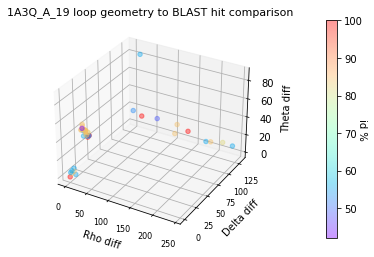

In [10]:
fig, ax = plt.subplots(subplot_kw=dict(projection="3d"))
c = identities
sc = ax.scatter(Rholist,Deltalist,Thetalist, alpha=0.4, c=c, cmap='rainbow', s=20)

ax.set_xlabel('Rho diff')
ax.set_ylabel('Delta diff')
ax.set_zlabel('Theta diff')
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

cbar = plt.colorbar(sc, pad=0.2)
cbar.set_label('id %', rotation=270)
plt.title("1A3Q_A_19 loop geometry to BLAST hit comparison",fontsize=11)
plt.show()

#### Repeat, but this time with an alpha helix-helix 310 from 5KRB

In [27]:
path = new.get_PDB("5KRB")
proteinmatch = PDB(path)
Chain1 = proteinmatch.get_chain_by_id("B")
Chain1.calculate_dssp()
Chain1.calculate_archs()
sequence = Chain1.protein_sequence
blastresults = blast.execute_query_seq(sequenceID = "5KRB_B", sequence = sequence)




tempMatch = "<<<<<<<<" + Chain1.protein_sequence + ">>>>>>>>"
search = r'.{4}' + Chain1.archs[2].aminoacid_sequence + r'.{4}'
blastSearch = re.findall(search, tempMatch)[0].strip("<>")
tempblastresults = blast.execute_query_seq(sequenceID = Chain1.archs[2].identifier, sequence = blastSearch)
Rholist = []
Deltalist = []
Thetalist = []
identities = []
for hit in tempblastresults.get_hits():
	id,chain = hit.sequenceID.split("_")
	path = new.get_PDB(id)
	proteinmatch = PDB(path)
	Chain2 = proteinmatch.get_chain_by_id(chain)
	Chain2.calculate_dssp()
	Chain2.calculate_archs()
	for x in Chain2.archs:
		if x.aminoacid_sequence in hit.hit_seq:
			Rho = math.sqrt((Chain1.archs[2].rho - x.rho)**2)
			Delta = math.sqrt((Chain1.archs[2].delta - x.delta)**2)
			Theta = math.sqrt((Chain1.archs[2].theta - x.theta)**2)
			Distance = math.sqrt((Chain1.archs[2].cartesian_distance - x.cartesian_distance)**2)
			Rholist.append(Rho)
			Deltalist.append(Delta)
			Thetalist.append(Theta)
			identities.append(hit.identities_pec)


('5KRB_B.32.pdb', '5KRB_B.32.dssp')
('1DSZ_A.65.pdb', '1DSZ_A.65.dssp')
('1HRA_A.89.pdb', '1HRA_A.89.dssp')
('4CN3_D.9.pdb', '4CN3_D.9.dssp')
('4NQA_A.31.pdb', '4NQA_A.31.dssp')


truncated chain!4NQA_A.31.dssp
truncated chain!4NQA_A.31.dssp


('4NQA_H.36.pdb', '4NQA_H.36.dssp')


truncated chain!4NQA_H.36.dssp


('4UMM_A.53.pdb', '4UMM_A.53.dssp')
('1R0O_A.80.pdb', '1R0O_A.80.dssp')
('3DZU_A.56.pdb', '3DZU_A.56.dssp')


truncated chain!3DZU_A.56.dssp
truncated chain!3DZU_A.56.dssp


('2HAN_A.35.pdb', '2HAN_A.35.dssp')
('3E00_A.67.pdb', '3E00_A.67.dssp')


truncated chain!3E00_A.67.dssp
truncated chain!3E00_A.67.dssp


('3DZY_A.85.pdb', '3DZY_A.85.dssp')


truncated chain!3DZY_A.85.dssp


('1R0N_A.0.pdb', '1R0N_A.0.dssp')
('4CN3_B.39.pdb', '4CN3_B.39.dssp')
('1RXR_A.91.pdb', '1RXR_A.91.dssp')
('4CN3_A.1.pdb', '4CN3_A.1.dssp')
('4CN7_E.52.pdb', '4CN7_E.52.dssp')
('4CN7_A.95.pdb', '4CN7_A.95.dssp')
('4CN5_A.45.pdb', '4CN5_A.45.dssp')
('4CN3_C.100.pdb', '4CN3_C.100.dssp')
('1BY4_D.1.pdb', '1BY4_D.1.dssp')
('1BY4_A.5.pdb', '1BY4_A.5.dssp')
('4CN7_F.75.pdb', '4CN7_F.75.dssp')
('4CN2_C.57.pdb', '4CN2_C.57.dssp')
('4CN7_B.52.pdb', '4CN7_B.52.dssp')
('2NLL_A.83.pdb', '2NLL_A.83.dssp')
('1YNW_B.61.pdb', '1YNW_B.61.dssp')
('1BY4_C.25.pdb', '1BY4_C.25.dssp')
('1BY4_B.42.pdb', '1BY4_B.42.dssp')
('1DSZ_B.12.pdb', '1DSZ_B.12.dssp')
('4CN2_D.9.pdb', '4CN2_D.9.dssp')
('4CN5_B.99.pdb', '4CN5_B.99.dssp')


truncated chain!4CN5_B.99.dssp


('3DZY_D.79.pdb', '3DZY_D.79.dssp')


truncated chain!3DZY_D.79.dssp


('3DZU_D.87.pdb', '3DZU_D.87.dssp')


truncated chain!3DZU_D.87.dssp


('3E00_D.46.pdb', '3E00_D.46.dssp')


truncated chain!3E00_D.46.dssp


('2A66_A.43.pdb', '2A66_A.43.dssp')
('1CIT_A.38.pdb', '1CIT_A.38.dssp')
('2FF0_A.83.pdb', '2FF0_A.83.dssp')
('2EBL_A.93.pdb', '2EBL_A.93.dssp')
('1GA5_E.16.pdb', '1GA5_E.16.dssp')
('1HLZ_A.70.pdb', '1HLZ_A.70.dssp')
('1GA5_A.95.pdb', '1GA5_A.95.dssp')
('1GA5_F.6.pdb', '1GA5_F.6.dssp')
('1A6Y_B.89.pdb', '1A6Y_B.89.dssp')
('1GA5_B.11.pdb', '1GA5_B.11.dssp')
('1A6Y_A.32.pdb', '1A6Y_A.32.dssp')
('1HLZ_B.48.pdb', '1HLZ_B.48.dssp')
('3CBB_A.48.pdb', '3CBB_A.48.dssp')
('3CBB_B.64.pdb', '3CBB_B.64.dssp')
('4IQR_A.97.pdb', '4IQR_A.97.dssp')


truncated chain!4IQR_A.97.dssp


('4IQR_E.64.pdb', '4IQR_E.64.dssp')


truncated chain!4IQR_E.64.dssp


('4IQR_B.77.pdb', '4IQR_B.77.dssp')


truncated chain!4IQR_B.77.dssp


('4IQR_F.40.pdb', '4IQR_F.40.dssp')


truncated chain!4IQR_F.40.dssp


('4OLN_B.83.pdb', '4OLN_B.83.dssp')


truncated chain!4OLN_B.83.dssp


('4OLN_A.90.pdb', '4OLN_A.90.dssp')


truncated chain!4OLN_A.90.dssp


('1YNW_A.74.pdb', '1YNW_A.74.dssp')
('1R0O_B.54.pdb', '1R0O_B.54.dssp')
('4UMM_E.96.pdb', '4UMM_E.96.dssp')
('1HCQ_B.45.pdb', '1HCQ_B.45.dssp')
('4AA6_B.75.pdb', '4AA6_B.75.dssp')


truncated chain!4AA6_B.75.dssp


('1HCQ_E.70.pdb', '1HCQ_E.70.dssp')


truncated chain!1HCQ_E.70.dssp


('1HCQ_A.54.pdb', '1HCQ_A.54.dssp')
('1HCP_A.46.pdb', '1HCP_A.46.dssp')
('2HAN_B.84.pdb', '2HAN_B.84.dssp')
('1R0N_B.22.pdb', '1R0N_B.22.dssp')
('1KB2_B.10.pdb', '1KB2_B.10.dssp')
('4AA6_F.3.pdb', '4AA6_F.3.dssp')


truncated chain!4AA6_F.3.dssp


('1KB2_A.95.pdb', '1KB2_A.95.dssp')
('1KB4_B.74.pdb', '1KB4_B.74.dssp')
('1KB6_A.89.pdb', '1KB6_A.89.dssp')
('1HCQ_F.95.pdb', '1HCQ_F.95.dssp')


truncated chain!1HCQ_F.95.dssp


('1KB6_B.12.pdb', '1KB6_B.12.dssp')
('1KB4_A.74.pdb', '1KB4_A.74.dssp')
('4AA6_A.40.pdb', '4AA6_A.40.dssp')


truncated chain!4AA6_A.40.dssp


('4AA6_E.11.pdb', '4AA6_E.11.dssp')


truncated chain!4AA6_E.11.dssp


('4NQA_I.79.pdb', '4NQA_I.79.dssp')
('2ENV_A.29.pdb', '2ENV_A.29.dssp')
('4NQA_B.12.pdb', '4NQA_B.12.dssp')


truncated chain!4NQA_B.12.dssp


('3M9E_A.21.pdb', '3M9E_A.21.dssp')
('3M9E_B.66.pdb', '3M9E_B.66.dssp')
('4OND_B.62.pdb', '4OND_B.62.dssp')
('4OND_F.79.pdb', '4OND_F.79.dssp')
('4OND_E.75.pdb', '4OND_E.75.dssp')
('3M9E_E.76.pdb', '3M9E_E.76.dssp')
('4OND_A.14.pdb', '4OND_A.14.dssp')
('2NLL_B.94.pdb', '2NLL_B.94.dssp')
('3M9E_F.27.pdb', '3M9E_F.27.dssp')
('1LAT_A.94.pdb', '1LAT_A.94.dssp')
('1LAT_B.55.pdb', '1LAT_B.55.dssp')
('1LO1_A.62.pdb', '1LO1_A.62.dssp')
('4HN6_B.7.pdb', '4HN6_B.7.dssp')
('4HN6_A.13.pdb', '4HN6_A.13.dssp')
('4TNT_B.12.pdb', '4TNT_B.12.dssp')
('4TNT_A.33.pdb', '4TNT_A.33.dssp')
('4OOR_E.53.pdb', '4OOR_E.53.dssp')
('4OV7_E.73.pdb', '4OV7_E.73.dssp')
('4OOR_A.58.pdb', '4OOR_A.58.dssp')
('4OV7_A.60.pdb', '4OV7_A.60.dssp')
('4OOR_B.20.pdb', '4OOR_B.20.dssp')
('4OV7_B.91.pdb', '4OV7_B.91.dssp')
('4HN5_B.17.pdb', '4HN5_B.17.dssp')
('3G97_B.8.pdb', '3G97_B.8.dssp')
('4HN5_A.94.pdb', '4HN5_A.94.dssp')
('2GDA_A.85.pdb', '2GDA_A.85.dssp')
('1GDC_A.52.pdb', '1GDC_A.52.dssp')
('3G99_B.27.pdb', '3G99_B.27.dss

truncated chain!4OOR_F.41.dssp


('4OV7_F.17.pdb', '4OV7_F.17.dssp')


truncated chain!4OV7_F.17.dssp


('2C7A_A.84.pdb', '2C7A_A.84.dssp')
('2C7A_B.10.pdb', '2C7A_B.10.dssp')
('1R4I_A.70.pdb', '1R4I_A.70.dssp')
('1R4I_B.93.pdb', '1R4I_B.93.dssp')
('3G6T_B.37.pdb', '3G6T_B.37.dssp')
('3G6T_A.4.pdb', '3G6T_A.4.dssp')


#### Plotting results

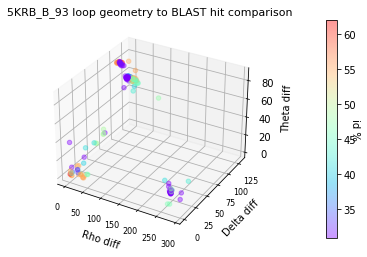

In [28]:
fig, ax = plt.subplots(subplot_kw=dict(projection="3d"))
c = identities
sc = ax.scatter(Rholist,Deltalist,Thetalist, alpha=0.4, c=c, cmap='rainbow', s=20)

ax.set_xlabel('Rho diff')
ax.set_ylabel('Delta diff')
ax.set_zlabel('Theta diff')
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

cbar = plt.colorbar(sc, pad=0.2)
cbar.set_label('id %', rotation=270)
plt.title("5KRB_B_93 loop geometry to BLAST hit comparison",fontsize=11)
plt.show()

## 5) Find the residues in an interface

In [29]:
protein = PDB("pdb1a3q.ent.gz")
complex = Complex(protein)
##### Here I am getting the amount of interfaces that were detected
len(complex.PPInterfaces)
##### This is the interface on the first chain in the interaction
for residue in complex.PPInterfaces[0]._view_interface_from(1):
	print(str(residue.number) + " " + residue._type)
##### This is the interface on the second chain in the interaction
for residue in complex.PPInterfaces[0]._view_interface_from(2):
	print(str(residue.number) + " " + residue._type)
##### The above prints out the name and number of each residue if you want to get the actual residue object itself you simply call residue. 

234 ASP
251 ASP
231 SER
252 LYS
286 ALA
249 LEU
287 ILE
247 TYR
288 VAL
232 ARG
283 LYS
248 LEU
284 GLN
229 LYS
230 ILE
233 MET
285 TYR
57 CYS
245 GLU
250 CYS
282 HIS
281 VAL
235 LYS
246 VAL
253 VAL
276 PHE
248 LEU
282 HIS
247 TYR
284 GLN
286 ALA
279 THR
287 ILE
281 VAL
285 TYR
288 VAL
283 LYS
249 LEU
245 GLU
144 LYS
235 LYS
280 ASP
246 VAL
234 ASP
232 ARG


## 6) Interface summary statistics

In [30]:
## Finding the percentage of contact residues that are hydrophobic

# Define hydrophobic Amino Acids
hydrophobic = ['PHE', 'LEU', 'ILE', 'TYR', 'TRP', 'VAL', 'MET', 'PRO']
i = 0
x = 0
for contact in complex.PPInterfaces[0].contacts:
	if contact.aminoacid1.standard_type in hydrophobic:
		i+=1
	if contact.aminoacid2.standard_type in hydrophobic:
		x+=1
print("Contact residue hydrophobicity is:\nChain1:{0}% Chain2:{1}% ".format(i/len(complex.PPInterfaces[0].contacts),x/len(complex.PPInterfaces[0].contacts)))


## Percentage of contact residues that are exposed

# First the dssp for both chains in the complex interface must be calculated
complex.pdb.get_chain_by_id("A").calculate_dssp()
complex.pdb.get_chain_by_id("B").calculate_dssp()
i = 0
x = 0
for contact in complex.PPInterfaces[0].contacts:
	if contact.aminoacid1.accessibility:
		i+=1
	if contact.aminoacid2.accessibility:
		x+=1
print("Contact residue exposure is:\nChain1:{0}% Chain2:{1}% ".format(i/len(complex.PPInterfaces[0].contacts),x/len(complex.PPInterfaces[0].contacts)))


Contact residue hydrophobicity is:
Chain1:0.39% Chain2:0.41% 
('1A3Q_A.59.pdb', '1A3Q_A.59.dssp')
('1A3Q_B.4.pdb', '1A3Q_B.4.dssp')
Contact residue exposure is:
Chain1:0.94% Chain2:0.93% 


truncated chain!1A3Q_A.59.dssp
truncated chain!1A3Q_B.4.dssp


## 7) Read in an mmcif file and blast getting results that pass the rost curve 

In [37]:
protein = PDB(cif_file = "1a3q.cif.gz")
ChainA = protein.get_chain_by_id("A")
sequence = ChainA.protein_sequence
blastresults = blast.execute_query_seq(sequenceID = "1A3Q_A", sequence = sequence)
for hit in blastresults.get_hits(tz_type = "ID"):
	print(hit.sequenceID, " ", hit.evaluate_Rost_twilight_zone() )

1A3Q_B   True
3DO7_B   True
1LE5_F   True
1LE5_B   True
3GUT_H   True
3GUT_F   True
3GUT_D   True
3GUT_B   True
1VKX_B   True
2I9T_B   True
1NFK_B   True
1NFK_A   True
1LEI_B   True
1LE9_F   True
1LE9_B   True
1OOA_B   True
1OOA_A   True
2V2T_B   True
2O61_B   True
1SVC_P   True
1GJI_B   True
1GJI_A   True
3JV6_D   True
3JV6_F   True
3JV5_A   True
3JV6_B   True
2I9T_A   True
1RAM_B   True
1RAM_A   True
2RAM_B   True
2RAM_A   True
3JV5_B   True
3JV5_D   True
3GUT_G   True
3GUT_E   True
3GUT_C   True
3GUT_A   True
1VKX_A   True
1LEI_A   True
1LE9_E   True
1LE9_A   True
1LE5_E   True
1LE5_A   True
3JV5_C   True
1NFI_A   True
1NFI_C   True
1IKN_A   True
2O61_A   True
2V2T_A   True
3DO7_A   True
1BFS_A   True
1IKN_C   True
3JV4_F   True
3JV4_D   True
3JV4_B   True
1NFI_D   True
1NFI_B   True
1U41_A   True
1U3Z_A   True
1U41_D   True
1U41_B   True
1U36_A   True
1U42_A   True
1U3J_A   True
1U3Y_A   True
1U41_C   True
3JV0_A   True
3JUZ_A   True
3JSS_A   True
1BFT_B   True
1BFT_A   True
1MY5_B